## Generate Drift Using MOA

In [2]:
from util.drift_generator import DriftGenerator
import numpy as np
import pandas as pd
import os

Randomly select streams to use for drift stream generation. Check summary statistics to determine value for n_drift during drift generation. 

In [3]:
# Parse source filepaths and directories
source_dir = os.path.abspath('./data/benchmark/IOPS')
drift_dir = os.path.abspath('./data/synthetic')
moa_path = os.path.abspath('../moa-release-2023.04.0/lib')
# Define parameters for drift generation
num_streams = 6
g = DriftGenerator(source_dir, drift_dir, moa_path, num_streams)

In [4]:
# If a CSV summarizing data source details is provided in the source directory, view table
# Summary CSVs can be generated manually using Pandas
df = g.get_source_summary()
df

,filename,len,num_anomalies,total_anom_cover,avg_anomaly_len,percent_anomalies
5,MBA_ECG14046_data_13.arff,229900,105,8265,78.714286,0.035950
13,MBA_ECG14046_data_20.arff,229900,150,12491,83.273333,0.054332
15,MBA_ECG14046_data_22.arff,229900,124,9675,78.024194,0.042084
17,MBA_ECG14046_data_24.arff,229900,60,4575,76.250000,0.019900
32,MBA_ECG14046_data_38.arff,229900,360,27841,77.336111,0.121100
37,MBA_ECG14046_data_42.arff,229900,572,44840,78.391608,0.195041


In [8]:
# Summary statistics of the source data streams can be used to influence parameter choice
df.describe()

,len,num_anomalies,total_anom_cover,avg_anomaly_len,percent_anomalies
count,6.0,6.000000,6.000000,6.000000,6.000000
mean,229900.0,228.500000,17947.833333,78.664922,0.078068
std,0.0,197.995707,15439.365977,2.421682,0.067157
min,229900.0,60.000000,4575.000000,76.250000,0.019900
25%,229900.0,109.750000,8617.500000,77.508132,0.037484
50%,229900.0,137.000000,11083.000000,78.207901,0.048208
75%,229900.0,307.500000,24003.500000,78.633616,0.104408
max,229900.0,572.000000,44840.000000,83.273333,0.195041


In [ ]:
# I.e. number of drifts in the final stream (n_drift) can be picked relative to the mean number 
# of anomalies in source streams
mean_num_anom = 228
percent = np.arange(0.1,0.8,0.1)
percent_anom = mean_num_anom * percent
pd.DataFrame([percent_anom], columns=percent)

,0.1,0.2,0.3,0.4,0.5,0.6,0.7
0,4.3,8.6,12.9,17.2,21.5,25.8,30.1


The following parameters can be assigned in the next cell to guide characteristics of the generated drift stream:

- `length`: int, total length of new stream
- `p_drift`: float, target percent of data points classified as drift
- `n_drift`: int, target number of drift sequences
- `p_before`: float, target percent of drift coming before anomaly
- `sub_dir`: string, name of subdirectory to export drift stream
- `dataset`: string, descriptor (name) or source dataset for identification
- `mode`: int, indicator for drift assembly method, options {0,1}, default 0
    - Mode 0: variable drift widths and positions
    - Mode 1: uniform drift widths and positions (helpful for high p_drift)
- Returns `output_path, drift_label, positions, streams, seq_before`

Note: Make sure that `sub_dir` exists in data/synthetic prior to generating the code.

Note: If you encounter trouble with generating large percentage drift, you can use `mode=1`.

In [9]:
# Determine paramter values for drift generation
length = 110633
n_drift = 10
p_drift = 0.35
p_drift_before = 0.5
sub_dir = 'test'
dataset = 'IOPS'

In [10]:
# A drift stream object is created
ds = g.run_generate_grad_stream_moa(
    length, 
    p_drift, 
    n_drift,
    p_drift_before, 
    sub_dir,
    dataset,
    mode=0 # 0 for variable drift widths and positions, 1 for uniform
)

Generating splits...
	Getting partitions...
	Getting order of drifts coming before anomaly...
	Getting drift center positions...
	Getting stream file cuts...
Done!
Getting stream file cuts...	Done!
Creating intermediate files...	Done!
Recursively generating MOA command...	Done!
Drift filename:  IOPS_grad_p34_n10_b50
Running terminal command...	


{M}assive {O}nline {A}nalysis
Version:  23.04 April 2023
Copyright: (C) 2007-2023 University of Waikato, Hamilton, New Zealand
Web: http://moa.cms.waikato.ac.nz/

                                                                               
Task completed in 0.45s (CPU time)



Stream written to ARFF file /Users/tammyz/Desktop/AnomalyDriftDetection/data/synthetic/test/IOPS_grad_p34_n10_b50.arff
Done!
Generating drift labels...	Done!


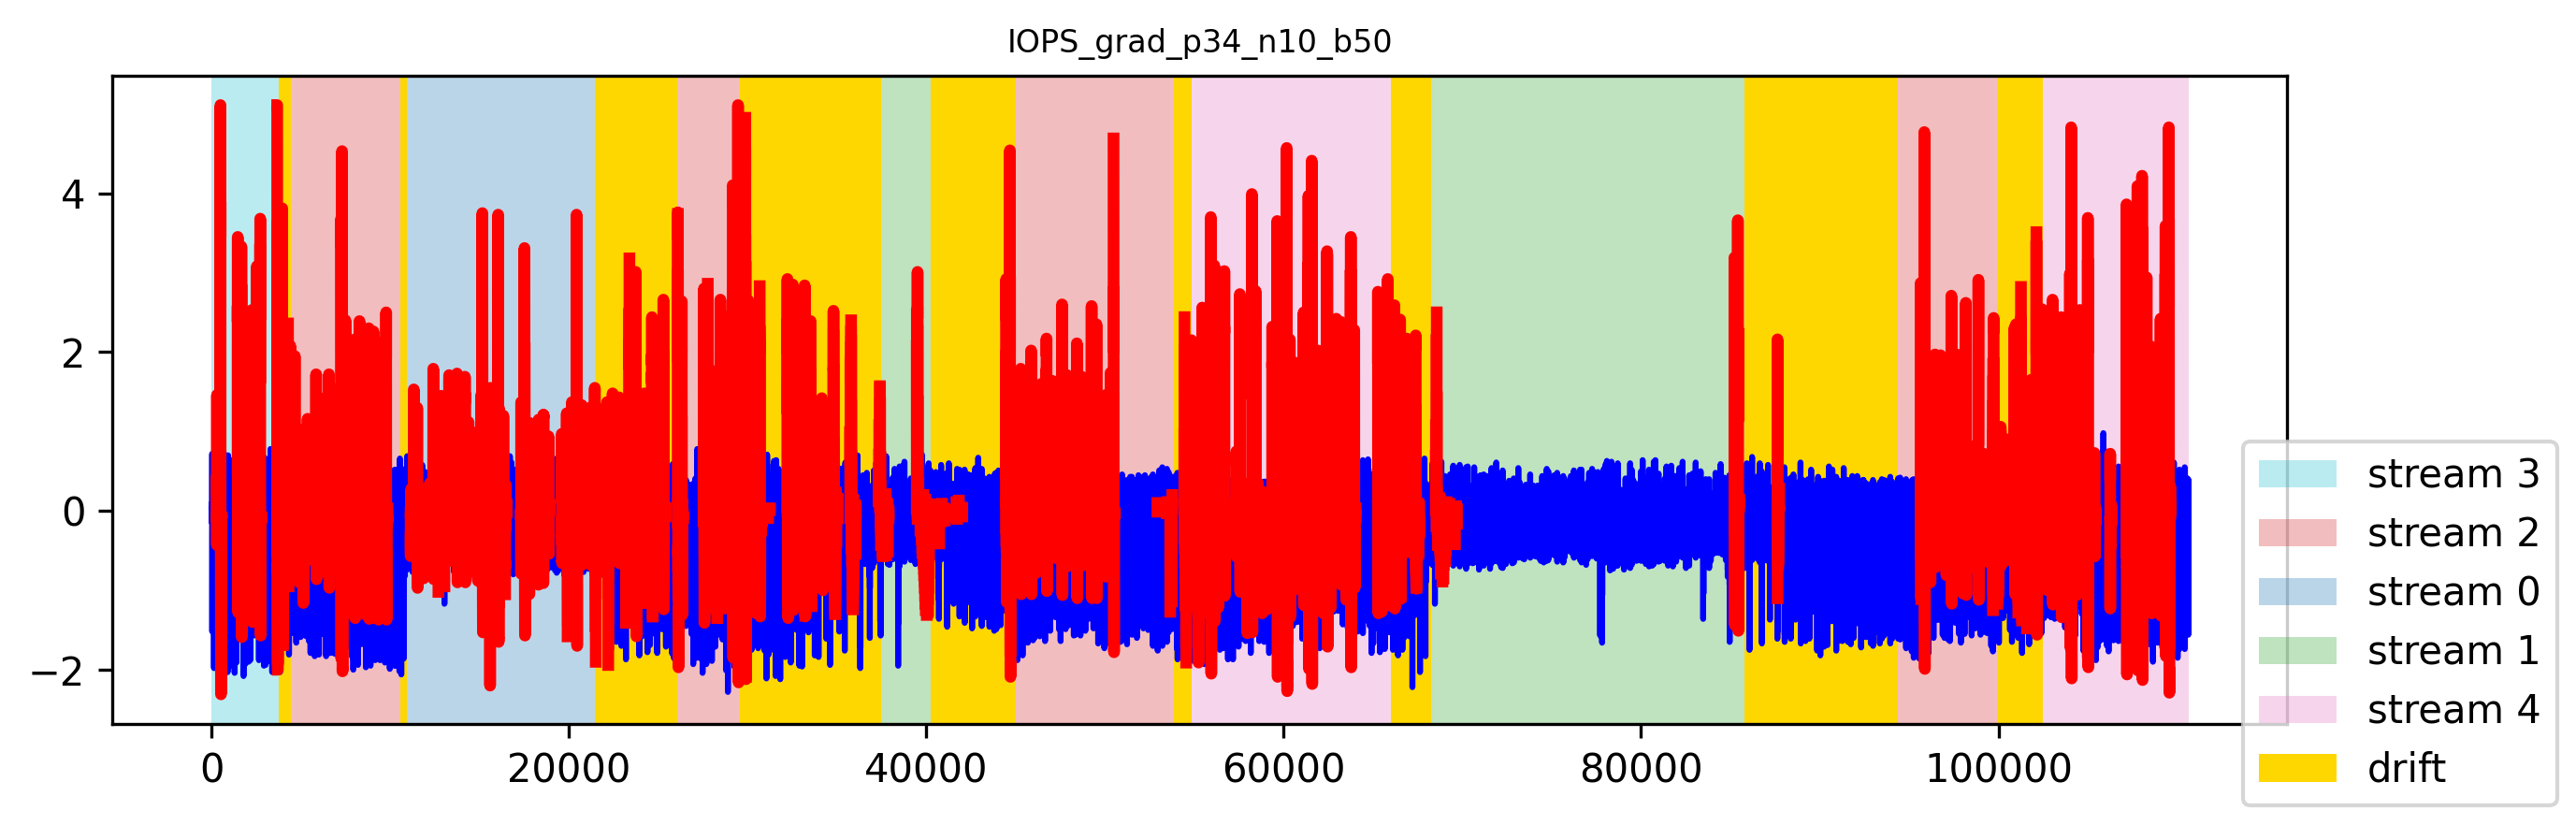

In [13]:
# Drifts can be plotted through various plotting methods through the DriftStream class, including:
#    plot_drift(), plot_all(), plot_drift_k(), plot_drift_k_with_source()
ds.plot_drift()

## Update an Existing Data Stream
An existing data stream can be read as a DriftStream object so that it can be manually modified to generate a new stream.

In [14]:
from util.stream import DriftStream

#### Read data and set up object to generate new data stream

In [15]:
drift_filepath = os.path.abspath('./data/synthetic/test/IOPS_grad_p34_n10_b50.arff')
source_dir = os.path.abspath('./data/benchmark/IOPS')
ds = DriftStream(drift_filepath, source_dir)

In [20]:
# Individual drift parameters can be altered
positions = ds.positions # this variable returns center positions of drifts, [0] appended to the fron of list
streams = ds.streams # stream identifiers for parent streams
seq_before = ds.seq_before # position of drift relative to stream anomaly
w_drift = ds.w_drift # width of drift

#### The following values can be modified individually to make changes to the data stream

In [37]:
# View drift parameters of various index values, according to kth drift and index range of width w
k = 5
w = 3
index = [i for i in range(k-w,k+w,1)]
pd.DataFrame(
    {
        'positions': positions[k-w:k+w],
        'streams': [(streams[i-1], streams[i]) for i in index], 
        'seq_before': seq_before[k-w-1:k+w-1], 
        'w_drift': w_drift[k-w-1:k+w-1] 
    }, 
    index=index
)

,positions,streams,seq_before,w_drift
2,10771,"(2, 0)",True,365
3,23781,"(0, 2)",False,4611
4,33534,"(2, 1)",True,7918
5,42619,"(1, 2)",False,4740
6,54355,"(2, 4)",True,1033
7,67111,"(4, 1)",False,2231


Manually adjust the parameters for a specific attribute below

In [ ]:
streams[60]

In [ ]:
positions[2] -= 1200

In [ ]:
w_drift[53] = 250

In [ ]:
seq_before[84] = True

In [ ]:
# Remove a drift by selecting the index to remove (r_i)
r_i = 3
positions = positions[:r_i] + positions[r_i+1:]
streams = streams[:r_i] + streams[r_i+1:]
w_drift[r_i] = w_drift[r_i-1] + w_drift[r_i]
w_drift = w_drift[:r_i-1] + w_drift[r_i:]
seq_before = seq_before[:r_i-1] + seq_before[r_i:]

In [ ]:
# Check the values for the same index window to see updates
index = [i for i in range(k-w,k+w,1)]
pd.DataFrame(
    {
        'positions': positions[k-w:k+w], # center position of drift
        'streams': [(streams[i-1], streams[i]) for i in index], # stream identifiers for parent streams
        'seq_before': seq_before[k-w-1:k+w-1], # position of drift relative to stream anomaly
        'w_drift': w_drift[k-w-1:k+w-1] # width of drift
    }, 
    index=index
)

,positions,streams (after),w_drift
30,98398,5,344
31,108581,4,5097
32,110528,0,24
33,116615,4,1675


#### Generate new data stream based on updated drift characteristics

In [ ]:
output_path = g.assemble_drift_stream(
    positions=positions[1:-1], # index slicing to account for [0] appended to positions in ds
    streams=streams,
    w_drift=w_drift,
    seq_before=seq_before,
    sub_dir='test',
    length=ds.length,
    dataset='IOPS'
)

Getting stream file cuts...	Done!
Creating intermediate files...	

Done!
Recursively generating MOA command...	Done!
Drift filename:  IOPS_grad_p35_n21_b50
Running terminal command...	


{M}assive {O}nline {A}nalysis
Version:  23.04 April 2023
Copyright: (C) 2007-2023 University of Waikato, Hamilton, New Zealand
Web: http://moa.cms.waikato.ac.nz/

                                                                               
Task completed in 0.51s (CPU time)



Stream written to ARFF file /home/zengt5/AnomalyDriftDetection/data/synthetic/n_drift/n_a50/IOPS_grad_p35_n21_b50.arff
Done!
Generating drift labels...	Done!
